# Análise da Perda de Funcionário

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import glob
import os

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style='darkgrid')
plt.style.use('seaborn')


## Baixando os Dados Utilizando a API do Kaggle

In [2]:
# Instalando a API do Kaggle
# !pip install kaggle --upgrade

In [3]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

ibm-hr-analytics-attrition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Lidando com o dado de resultado da API do Kaggle. Podemos observar, primeiramente, que o arquivo vem zipado, portanto, teremos que descompactá-lo para depois trabalhar com ele

In [4]:
# Importando todos os arquivos zip do diretório
zip_files = glob.glob('*.zip')
zip_files

['ibm-hr-analytics-attrition-dataset.zip']

In [5]:
for file in zip_files:
    with ZipFile(file, 'r') as zip:
        zip.extractall()
        n = 0
        for file in zip.namelist():
            if file.endswith('.csv'):
                n += 1
                os.rename(file, f'attrition_data{n}.csv')                
        zip.close()

In [6]:
z = ZipFile('ibm-hr-analytics-attrition-dataset.zip')
z.namelist()

['WA_Fn-UseC_-HR-Employee-Attrition.csv']

## Análise Exploratória de Dados

In [7]:
data = pd.read_csv("attrition_data1.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Das informações acima, podemos observar que a base de dados não possui colunas com valores nulos. Portanto, seguimos investigando alguns atributos

In [8]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Temos que a variável alvo "Attrition" está descrita de maneira categórica, algo que podemos modificar para que esta possa ser melhor abordada no futuro. Para isso, façamos a seguinte substituição: No -> 0, Yes -> 1

In [9]:
data_copy = deepcopy(data)
data_copy.loc[data_copy["Attrition"] == "Yes", "Attrition"] = 1
data_copy.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [10]:
data.loc[data["Attrition"]=="Yes", "Attrition"] = 1
data.loc[data["Attrition"] == "No", "Attrition"] = 0
data[["Attrition"]] = data[["Attrition"]].astype("int")

Isso poderá nos auxiliar a construir relações quantitativas melhores entre a variável alvo e as variáveis dependentes. Como podemos ver, há também um alto número de colunas na base de dados. Talvez um ponto interessante para que possamos reduzir essa quantidade de colunas é realizando uma feature importance

In [11]:
# Separando a variável alvo das variáveis dependentes
    # Variáveis dependentes
x_feature_importance = data.drop(columns="Attrition").select_dtypes(include=np.number)

x_features_names = x_feature_importance.columns

y_feature_importance = data[["Attrition"]]

In [12]:
# Dividindo a base de dados
x_train, x_test, y_train, y_test = train_test_split(x_feature_importance,
                                                    y_feature_importance,
                                                   test_size=0.3,
                                                   random_state=13)

In [13]:
x_train.to_numpy().shape, y_train.to_numpy().reshape(1,-1).shape

((1029, 26), (1, 1029))

In [14]:
forest_importance = RandomForestClassifier(random_state=13)
forest_importance.fit(x_train, y_train.values.ravel())
importances = forest_importance.feature_importances_


importances = permutation_importance(forest_importance,
                               x_test, y_test, n_repeats=50, random_state=13, n_jobs=2
                               )

In [15]:
importance_to_plot = list(importances.importances_mean)
importance_to_plot.sort()
features_importance = pd.Series(importance_to_plot, index=x_features_names)

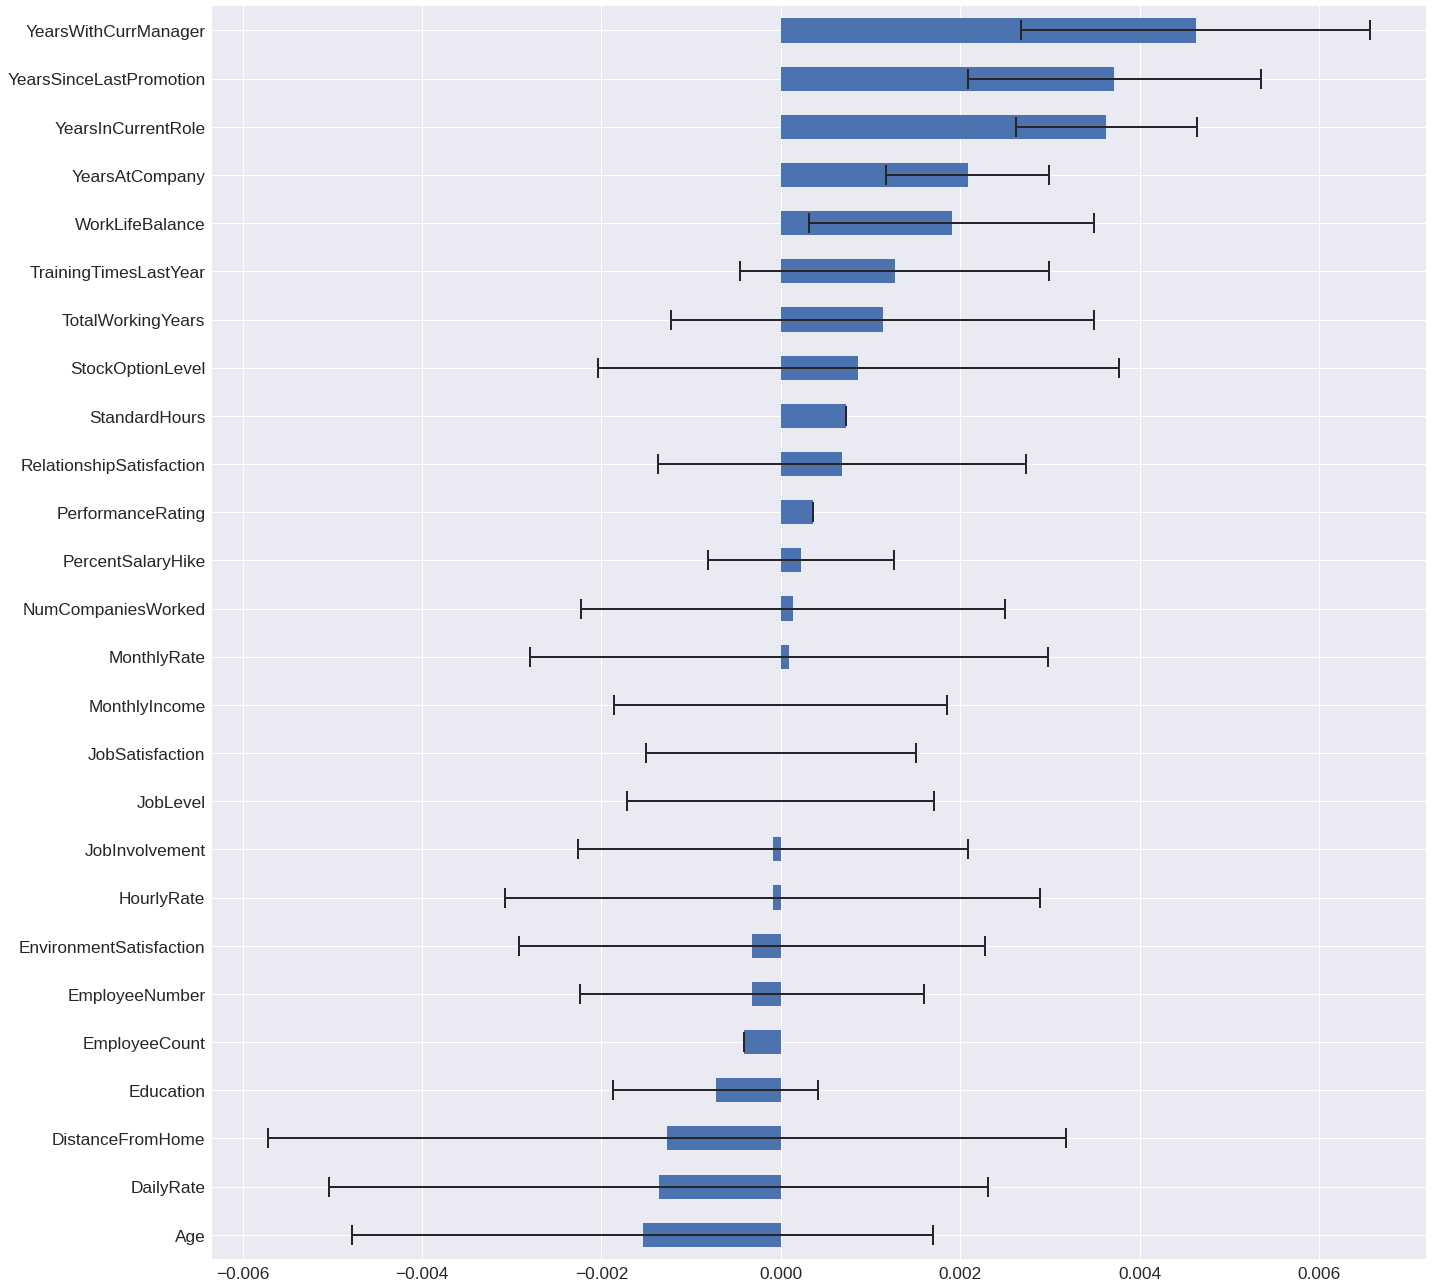

In [16]:
fig, ax = plt.subplots(figsize=(20,18))
features_importance.plot.barh(xerr=importances.importances_std, ax=ax,
                             error_kw={'elinewidth': 2, 'capsize': 10, 'capthick': 2})
ax.tick_params(labelsize='xx-large')
fig.tight_layout()
# ax.set_xticks(importances.importances_mean)
plt.show()

Esta análise, apesar de tomar apenas dados numéricos, excluindo os categóricos, possibilita que entendemos quais categóricos possivelmente podem ser utilizados para melhorar a análise.

Mas antes de partimos para a análise de dados categóricos, faremos algumas inferências a partir da importância dos atributos acima. 

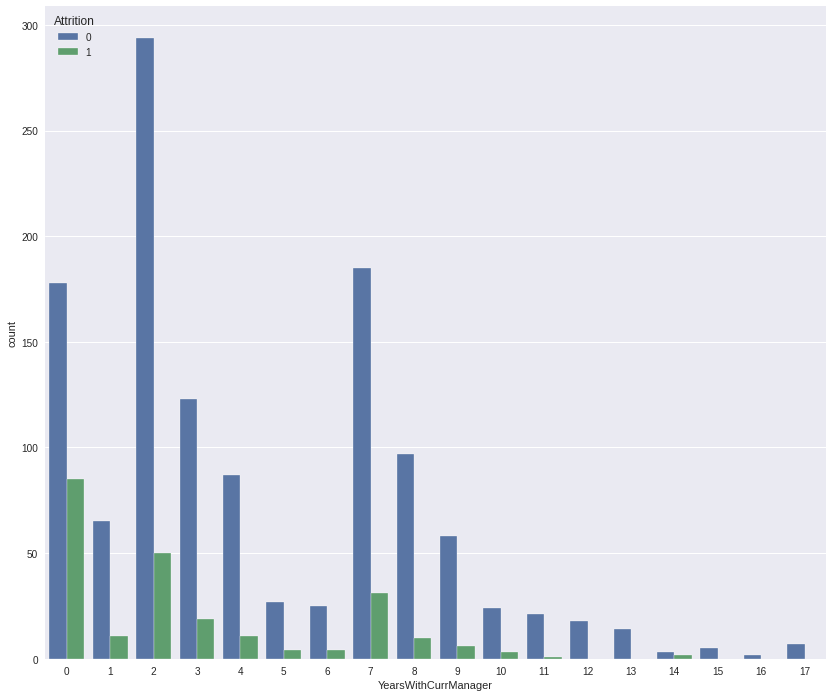

In [40]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsWithCurrManager, hue=data.Attrition)
plt.show()

No gráfico acima, é construída a relação entre a variável número de anos com o atual gerente e a variável alvo. Podemos observar que quanto maior o número de anos, menor a probabilidade de perder o empregado.

Outra variável que podemos observar é a de anos desde a última promoção.

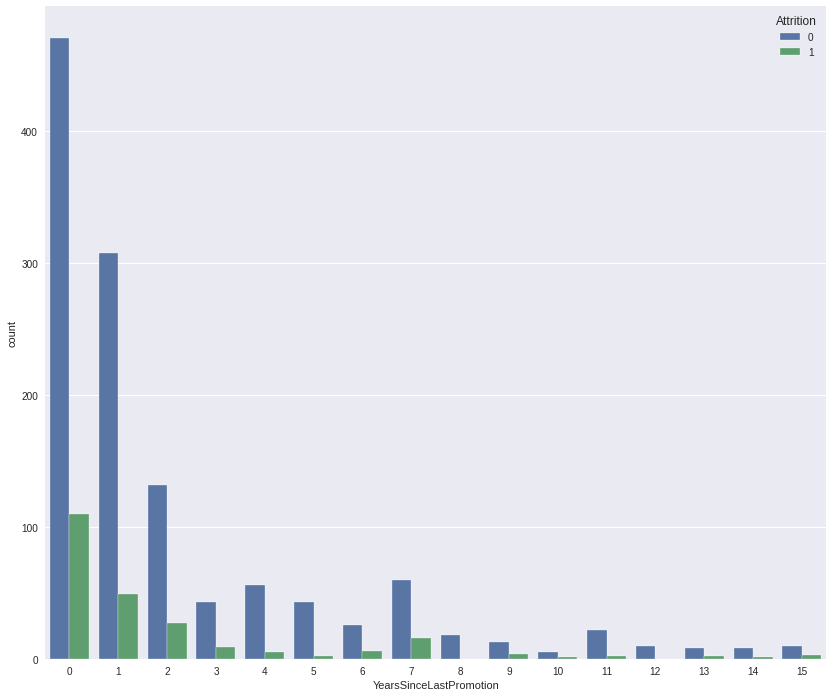

In [42]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsSinceLastPromotion, hue=data.Attrition)
plt.show()

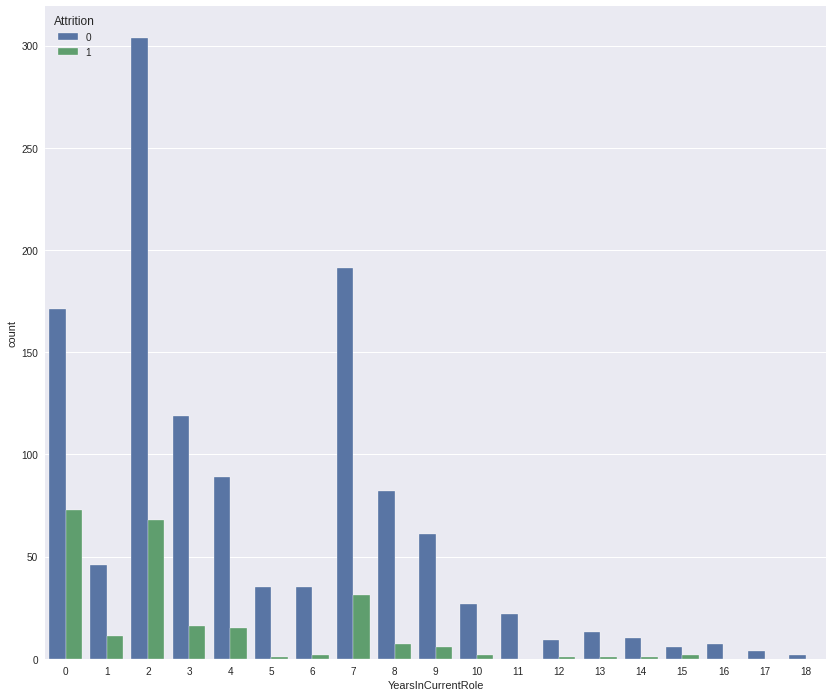

In [43]:
figs, axs = plt.subplots(figsize=(14,12), nrows=1, ncols=1, squeeze=False)
sns.countplot(x=data.YearsInCurrentRole, hue=data.Attrition)
plt.show()